In [26]:
import numpy as np
import seaborn as sb

from Data_manager.split_functions.split_train_validation_random_holdout import \
        split_train_in_two_percentage_global_sample
from Utils.recsys2022DataReader import *
import matplotlib.pyplot as plt

In [27]:
URM = createURM()

C:\Users\Mike\PycharmProjects\recsys-challenge-2022-Pancini-Vitali\Utils\recsys2022DataReader.py:20: DtypeWarning: Columns (2) have mixed types. Specify dtype option on import or set low_memory=False.
  dataset = pd.read_csv(urmPath)


In [28]:
ICM = createSmallICM()

In [29]:
profile_length = np.ediff1d(URM.indptr)
profile_length, profile_length.shape

(array([ 66,  21, 103, ...,  23,  53,  23], dtype=int32), (41629,))

In [30]:
block_size = int(len(profile_length)*0.25)
block_size

10407

In [31]:
sorted_users = np.argsort(profile_length)
sorted_users

array([38400, 30257, 25061, ..., 19407,  8693, 12454], dtype=int64)

In [32]:
URM_train, URM_test = split_train_in_two_percentage_global_sample(URM, train_percentage=0.85)

<AxesSubplot:ylabel='Count'>

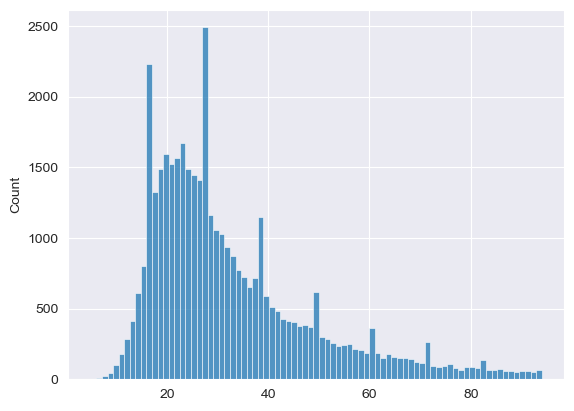

In [33]:
interactions = []
for i in range(41629):
    interactions.append(len(URM[i,:].nonzero()[0]))

#interactions = np.array(inter).sort()
interactions_to_plot = sorted(interactions)[:40000]

sb.histplot(interactions_to_plot)

In [34]:
from Recommenders.NonPersonalizedRecommender import TopPop
from Recommenders.KNN.ItemKNNCFRecommenderPLUS import ItemKNNCFRecommender
from Recommenders.SLIM.SLIMElasticNetRecommender import MultiThreadSLIM_SLIMElasticNetRecommender
from Recommenders.GraphBased.P3alphaRecommender import P3alphaRecommender
from Recommenders.GraphBased.RP3betaRecommender import RP3betaRecommender
from Recommenders.Implicit.ImplicitALSRecommender import ImplicitALSRecommender

MAP_recommender_per_group = {}

collaborative_recommender_class = {"ItemKNNCF": ItemKNNCFRecommender,
                                   "RP3beta": RP3betaRecommender,
                                   #"SlimElasticNet": MultiThreadSLIM_SLIMElasticNetRecommender,
                                   }

recommender_object_dict = {}

for label, recommender_class in collaborative_recommender_class.items():
    recommender_object = recommender_class(URM_train)
    if(label == 'ItemKNNCF'):
        recommender_object.fit(ICM=ICM, shrink=199.9030743355846, topK=286, similarity='cosine', normalization='bm25')
    elif(label == 'RP3beta'):
        recommender_object.fit(alpha=0.5674554399991163, beta=0.38051048617892586, topK=100)
    elif(label == 'SlimElasticNet'):
        recommender_object.fit(topK=359, alpha=0.04183472018614359, l1_ratio=0.03260349571135893)
    else:
        recommender_object.fit()

    recommender_object_dict[label] = recommender_object

Done: 100%|██████████| 24507/24507 [00:02<00:00, 12057.39it/s]            


RP3betaRecommender: Similarity column 24507 (100.0%), 2607.93 column/sec. Elapsed time 9.40 sec


In [35]:
cutoff = 10
from Evaluation.Evaluator import EvaluatorHoldout

list_group_interactions = [[0, 22] , [23, 35], [36, max(interactions)]]
for group_id in range(3):
    lower_bound = list_group_interactions[group_id][0]
    higher_bound = list_group_interactions[group_id][1]

    users_in_group = [user_id for user_id in range(len(interactions)) if (lower_bound <= interactions[user_id] <= higher_bound)]
    users_in_group_p_len = profile_length[users_in_group]

    users_not_in_group_flag = np.isin(sorted_users, users_in_group, invert=True)
    users_not_in_group = sorted_users[users_not_in_group_flag]

    print(f"Evaluating group: {group_id}")

    evaluator_test = EvaluatorHoldout(URM_test, cutoff_list=[cutoff], ignore_users=users_not_in_group)

    for label, recommender in recommender_object_dict.items():
        result_df, _ = evaluator_test.evaluateRecommender(recommender)
        if label in MAP_recommender_per_group:
            MAP_recommender_per_group[label].append(result_df.loc[cutoff]["MAP"])
        else:
            MAP_recommender_per_group[label] = [result_df.loc[cutoff]["MAP"]]

Evaluating group: 0
EvaluatorHoldout: Ignoring 879 ( 2.1%) Users that have less than 1 test interactions
EvaluatorHoldout: Ignoring 29442 Users
EvaluatorHoldout: Processed 11491 (100.0%) in 8.04 sec. Users per second: 1429
EvaluatorHoldout: Processed 11491 (100.0%) in 6.83 sec. Users per second: 1682
Evaluating group: 1
EvaluatorHoldout: Ignoring 879 ( 2.1%) Users that have less than 1 test interactions
EvaluatorHoldout: Ignoring 26581 Users
EvaluatorHoldout: Processed 14873 (100.0%) in 10.07 sec. Users per second: 1477
EvaluatorHoldout: Processed 14873 (100.0%) in 8.85 sec. Users per second: 1681
Evaluating group: 2
EvaluatorHoldout: Ignoring 879 ( 2.1%) Users that have less than 1 test interactions
EvaluatorHoldout: Ignoring 27235 Users
EvaluatorHoldout: Processed 14386 (100.0%) in 11.48 sec. Users per second: 1253
EvaluatorHoldout: Processed 14386 (100.0%) in 9.17 sec. Users per second: 1569


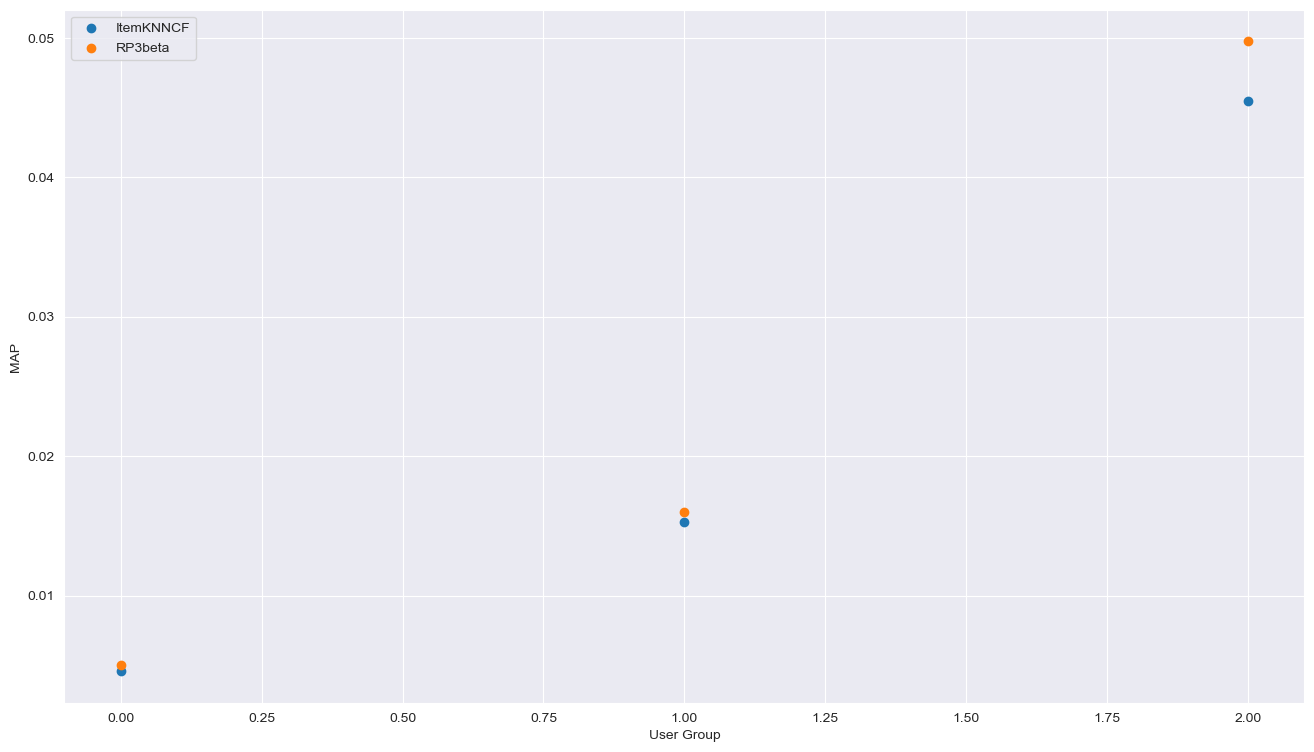

In [36]:
import matplotlib.pyplot as plt
%matplotlib inline

_ = plt.figure(figsize=(16, 9))
for label, recommender in recommender_object_dict.items():
    results = MAP_recommender_per_group[label]
    plt.scatter(x=np.arange(0,len(results)), y=results, label=label)
plt.ylabel('MAP')
plt.xlabel('User Group')
plt.legend()
plt.show()